Our goal here is to cluster our customers once again and check how our clusters change weeks after weeks. This will enable us to see when we will need to update our algorithm.

To do this, we will calculate the Adjusted Rand Index between a cluster made with out original data preprocessing and a cluster made with a new preprocessing taking into account the new data. Then, we will be able to see the evolution of the ARI weeks after weeks and see when an update is necessary.

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from datetime import date
from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
# To remove some warnings (setting with a copy)
pd.options.mode.chained_assignment = None

We will be using all our available data (so UK and the other countries).

In [3]:
# Loading data
df = pd.read_csv('static/customer_segmentation.csv', encoding='latin1')

We change our InvoiceDate column into a datetime column.

In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'] = df['InvoiceDate'].dt.to_period('D')
df['InvoiceDate'] = df['InvoiceDate'].astype('datetime64[ns]')

In [5]:
# We remove missing rows and columns we won't use in this analysis
df = df[df['CustomerID'].notnull()]
df = df.reset_index()
df = df.drop(['StockCode', 'Country', 'index'], axis=1)

We remove the order amounts that have a negative value (discounts or returned orders).

In [6]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
data_null = df[df['TotalAmount'] < 0]
data_null['Quantity'] = - data_null['Quantity']
data_null['TotalAmount'] = - data_null['TotalAmount']
data_null = data_null[['CustomerID', 'Description', 'Quantity', 'UnitPrice', 'TotalAmount']]

data_not_null = df[df['TotalAmount'] >= 0]
data_not_null['Quantity'] = - data_not_null['Quantity']
data_not_null['TotalAmount'] = - data_not_null['TotalAmount']
data_not_null = data_not_null[['CustomerID', 'Description', 'Quantity', 'UnitPrice', 'TotalAmount']]

df_concat = pd.concat([data_null, data_not_null])
df_concat = df_concat.drop_duplicates()
df_concat = df_concat.drop('TotalAmount', axis=1)

data_concat = pd.concat([df_concat, df])
null_quantity = data_concat[data_concat['Quantity'] < 0]
data_concat = data_concat.drop(null_quantity.index)
data_concat = data_concat.drop_duplicates(subset=['CustomerID', 'Description', 'Quantity', 'UnitPrice', 'TotalAmount'])
data_concat.head()

CustomerID                         Description  Quantity  UnitPrice   
47     17850.0           HAND WARMER RED POLKA DOT         6       1.85  \
48     17850.0              HAND WARMER UNION JACK         6       1.85   
49     17850.0  WHITE HANGING HEART T-LIGHT HOLDER         6       2.55   
50     17850.0                 WHITE METAL LANTERN         6       3.39   
51     17850.0      CREAM CUPID HEARTS COAT HANGER         8       2.75   

   InvoiceNo InvoiceDate  TotalAmount  
47    536372  2010-12-01        11.10  
48    536372  2010-12-01        11.10  
49    536373  2010-12-01        15.30  
50    536373  2010-12-01        20.34  
51    536373  2010-12-01        22.00

# Functions for RFM

Now, we will define several functions : a function to subset our dataframe based on dates and then functions to create our RFM features.

## Subset dates

In [7]:
def data_subset(data, beginning='2010-12-01', end='2011-12-09'):
    
    beginning = pd.to_datetime(beginning)
    end = pd.to_datetime(end)
    
    # Subsetting
    data = data[(data['InvoiceDate'] >= beginning) & (data['InvoiceDate'] <= end)]

    return data

## Recency

In [8]:
def recency(data):
    new_data = data.copy()
    last_day = new_data['InvoiceDate'].max()

    recency = []
    for value in new_data['InvoiceDate']:
        result = last_day - value
        recency.append(result.days)
    
    new_data['Recency'] = recency

    return new_data

## Frequency

In [9]:
def frequency(data):
    new_data = data.copy()

    frequencies_series = new_data.groupby('CustomerID')['InvoiceNo'].unique()

    nb_orders = []
    for value in frequencies_series.values:
        nb_orders.append(len(value))

    indexes = frequencies_series.index

    df_freq = pd.DataFrame(nb_orders, columns=['NbOrder'])
    df_freq['CustomerID'] = indexes

    df_merge = new_data.merge(df_freq, on='CustomerID')

    df_merge['Frequency'] = df_merge['NbOrder']

    return df_merge

## Monetary

In [10]:
def monetary(data):
    new_data = data.copy()
    new_data['Monetary'] = new_data['Quantity'] * new_data['UnitPrice']

    return new_data

## Creating our RFM features

In [11]:
def rfm(data):
    new_data = data.copy()

    # We apply our previously define functions
    new_data = recency(new_data)
    new_data = frequency(new_data)
    new_data = monetary(new_data)

    # We only keep the features we are interested in
    df_rfm = new_data[['CustomerID', 'Recency', 'Frequency', 'Monetary']]

    # We GroupBy to get the total order value per customer
    monetary_sum = df_rfm.groupby('CustomerID')['Monetary'].sum()
    monetary_sum = pd.DataFrame(monetary_sum)
    monetary_sum = monetary_sum.reset_index()

    # We remove rows with very small total order value
    # Main issue is that some people returned their order and
    # either have a total of 0 or they gained money on it
    # To be safe, we remove those very few rows
    monetary_sum = monetary_sum[monetary_sum['Monetary'] > 5]

    df_rfm = df_rfm.drop('Monetary', axis=1)
    df_rfm = df_rfm.merge(monetary_sum, on='CustomerID')
    df_rfm = df_rfm.sort_values(['CustomerID', 'Recency'])
    df_rfm = df_rfm.drop_duplicates(subset='CustomerID')
    df_rfm = df_rfm.reset_index()
    df_rfm = df_rfm.drop(['index', 'CustomerID'], axis=1)

    return df_rfm

# Score ARI: at which frequency do we need to update our clusters

In [12]:
# We check what if the first and last dates available in our original dataframe
last_day = df[f'InvoiceDate'].max()
first_day = df['InvoiceDate'].min()
print('Last Day:', last_day)
print('First Day:', first_day)

Last Day: 2011-12-09 00:00:00
First Day: 2010-12-01 00:00:00


We split the dataset into two parts: the first 9 months and then the last 3 months.

In [13]:
df_rfm = data_subset(data_concat, beginning='2010-12-01', end='2011-09-01')
df_rfm_ini = rfm(df_rfm)
print(df_rfm_ini.shape)
df_rfm_ini.head()

(1602, 3)


Recency  Frequency  Monetary
0       30          3    463.41
1      149          1     40.00
2      163          2    160.33
3      146          1     43.80
4       90          3    310.30

In [14]:
# We can see that some people like to order a lot
df_rfm_ini.describe()

Recency    Frequency      Monetary
count  1602.000000  1602.000000   1602.000000
mean     63.584894     3.579900    383.292091
std      62.502802     5.552896   1438.844267
min       0.000000     1.000000      5.040000
25%      16.000000     1.000000     35.400000
50%      42.000000     2.000000    100.680000
75%      91.000000     4.000000    291.115000
max     274.000000    89.000000  36688.960000

We do a small preprocessing of our features :

- We apply a log function to the "Frequency" and "Monetary" features which are very skewed,
- We scale all our features.

We need to to it once for our original dataframe (9 months of data) and we'll use this preprocessing later on.

In [15]:
# Applying a log function
df_rfm_ini['Frequency'] = np.log(df_rfm_ini['Frequency'])
df_rfm_ini['Monetary'] = np.log(df_rfm_ini['Monetary'])

In [16]:
# Scaling our data
scaler_ini = StandardScaler()
scaler_ini.fit(df_rfm_ini[['Recency', 'Frequency', 'Monetary']])

df_rfm_ini[['Recency', 'Frequency', 'Monetary']] = scaler_ini.transform(df_rfm_ini[['Recency', 'Frequency', 'Monetary']])
df_rfm_ini = pd.DataFrame(df_rfm_ini, columns=['Recency', 'Frequency', 'Monetary'])
df_rfm_ini.head()

Recency  Frequency  Monetary
0 -0.537502   0.308927  0.985611
1  1.367007  -1.014213 -0.666035
2  1.591067  -0.179405  0.270014
3  1.318994  -1.014213 -0.604847
4  0.422755   0.308927  0.715202

We create a preprocessing function to be able to compare two kinds of preprocessing (one taking into account the new data, the other using our old data).

In [17]:
def preprocessing(data):
    new_data = data.copy()
    new_data['Frequency'] = np.log(new_data['Frequency'])
    new_data['Monetary'] = np.log(new_data['Monetary'])

    scaler = StandardScaler()
    scaler.fit(new_data[['Recency', 'Frequency', 'Monetary']])

    new_data[['Recency', 'Frequency', 'Monetary']] = scaler.transform(new_data[['Recency', 'Frequency', 'Monetary']])
    new_data = pd.DataFrame(new_data, columns=['Recency', 'Frequency', 'Monetary'])

    return new_data

From pour previous analysis, we know we can cluster our clients into 4 groups.

We will use a specific random_state to have smoother results. No matter the random_state, results are fundamentally the same.

In [26]:
kmeans = KMeans(n_init='auto', n_clusters=4, random_state=58)
kmeans.fit(df_rfm_ini)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([558, 231, 301, 512]))

Now, we want to use our initial preprocessing for the final 3 months of our dataset and then compare with a new preprocessing that would be done each time.

In [27]:
# We start by using the old preprocessing
list_df_old = []

for i in tqdm(range(0, 112, 7)):
    # We create the subset
    new_data = data_subset(data_concat, beginning=date(2010, 12, 1), end=date(2011, 9, 1) + timedelta(days=i))

    # We get the features
    new_data_rfm = rfm(new_data)

    # We do the original preprocessing
    new_data_rfm['Frequency'] = np.log(new_data_rfm['Frequency'])
    new_data_rfm['Monetary'] = np.log(new_data_rfm['Monetary'])

    new_data_rfm[['Recency', 'Frequency', 'Monetary']] = scaler_ini.transform(new_data_rfm[['Recency', 'Frequency', 'Monetary']])
    new_data_rfm = pd.DataFrame(new_data_rfm, columns=['Recency', 'Frequency', 'Monetary'])

    # We predict the clusters with our kmeans model
    y = kmeans.predict(new_data_rfm)
    new_data_rfm['old_cluster'] = y
    list_df_old.append(new_data_rfm)

# We continue by using a new preprocessing each time
list_df_new = []

for i in tqdm(range(0, 112, 7)):
    # We create the subset
    new_data = data_subset(data_concat, beginning=date(2010, 12, 1), end=date(2011, 9, 1) + timedelta(days=i))

    # We get the features
    new_data_rfm = rfm(new_data)

    # We aplly a new preprocessing
    new_data_rfm = preprocessing(new_data_rfm)
    
    # We predict the clusters by fitting to the new data
    y = kmeans.fit_predict(new_data_rfm)
    new_data_rfm['new_cluster'] = y
    list_df_new.append(new_data_rfm)

100%|██████████| 16/16 [00:01<00:00,  8.66it/s]


In [28]:
# We calcule the ARI between the old and new clustering
list_ari = []
for i in range(len(list_df_new)):
    list_ari.append(round(adjusted_rand_score(list_df_new[i]['new_cluster'], list_df_old[i]['old_cluster']), 4))

# When the ARI drops below 0.8, an update is necessary
update = 0
for i in range(len(list_ari)):
    if list_ari[i] < 0.85:
        update = i - 1
        break

# Update frequency:
print(f'Update needed every {update} weeks.')

Update needed every 4 weeks.


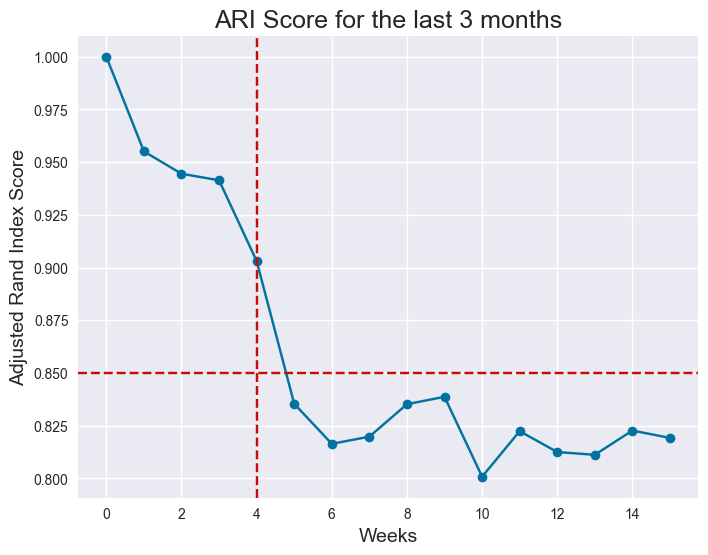

In [30]:
# Graphically
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(8, 6))
plt.plot(list_ari, marker='o')
plt.axhline(y=0.85, color='r', linestyle='--')
plt.axvline(x=update, color='r', linestyle='--')

plt.title("ARI Score for the last 3 months", fontsize=18)
plt.xlabel('Weeks', fontsize=14)
plt.ylabel('Adjusted Rand Index Score', fontsize=14)
plt.show()